In [1]:
import sys
sys.path.append("..")

from tqdm import tqdm
from dapper.mods.Lorenz96 import dstep_dx, step, x0
import dapper.mods as modelling
import dapper as dpr
import dapper.da_methods as da
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()
import pandas as pd
from coda.datamodule.observational_models import RandomObservationModel
from coda.datamodule.DataLoader import L96InferenceDataset
from mdml_tools.simulators import L96Simulator
from torch.utils.data import DataLoader
import h5py

In [2]:
random_seed: int = 261197


grid_size: int = 36
forcing: float = 10.0
process_noise: float = 0.0
time_step: float = 0.01

observation_noise: float = 1.0
mask_fraction: float = 0.75
steps_between_observation: int = 1

device = "cpu"
pretrained_network_checkpoint = "/gpfs/work/zinchenk/final_experiments/140424_imperfect_forward_operator/pretrain_data_assimilation/multirun/2024-03-14/03-19-59/0/logs/checkpoints/assimilation_network.ckpt"
trained_network_checkpoint = "/gpfs/work/zinchenk/final_experiments/300424_parametrization_learning/parametrization_learning/multirun/2024-04-30/13-17-52/0/logs/checkpoints/assimilation_network.ckpt"
# path to simulator checkpoint with coupled parametrization
simulator_checkpoint = "/gpfs/work/zinchenk/final_experiments/300424_parametrization_learning/parametrization_learning/multirun/2024-04-30/13-17-52/0/logs/checkpoints/simulator.ckpt"

test_data_path = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/test/lorenz-two_level-grid_36-forcing_10.0-dt_0.01-rk4.h5"
# test_data_path = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/test/lorenz-one_level-grid_40-forcing_8.0-dt_0.01-rk4.h5"


In [3]:
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [4]:
with h5py.File(test_data_path, "r") as file:
    ground_truth = torch.tensor(file["first_level"][0], device=device, requires_grad=False)

In [5]:
number_of_observations = ground_truth.shape[0]

In [6]:
pretrained_network = torch.load(pretrained_network_checkpoint, map_location=device)
trained_network = torch.load(trained_network_checkpoint, map_location=device)
simulator = torch.load(simulator_checkpoint, map_location=device)
parametrization = simulator.parametrization

In [7]:
observation_operator = RandomObservationModel(
    additional_noise_std=observation_noise,
    random_mask_fraction=mask_fraction,
)

observations, mask_array = observation_operator.forward(ground_truth)
dataset = L96InferenceDataset(
    ground_truth_data=ground_truth.unsqueeze(0).to("cpu"),
    observation_model=observation_operator,
    input_window_extend=25,
    drop_edge_samples=False,
)
dataset.to(device)

loader = DataLoader(dataset, batch_size=number_of_observations, shuffle=False)

In [8]:
for batch in tqdm(loader):
    with torch.no_grad():
        analysis_pretrained = pretrained_network.forward(batch)
        analysis_trained = trained_network.forward(batch)


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


In [9]:
Nx = grid_size
Force = forcing
x_initial = x0(grid_size)
dynamical_operator = {
    'M': Nx,
    'model': step,
    'linear': dstep_dx,
    'noise': process_noise,
}

tseq = modelling.Chronology(dt=time_step, dko=steps_between_observation, Ko=number_of_observations-2, Tplot=0, BurnIn=5)

xx = ground_truth.numpy()
observations = dataset.observations.squeeze().numpy()[1:]
mask_array = dataset.mask.bool().squeeze().numpy()[1:]

yy = [observations[i, mask_array[i]] for i in range(observations.shape[0])]
yy = np.array(yy)

def observation_operator_dapper(t):
    jj = np.flatnonzero(mask_array[t])
    obs = modelling.Operator(**modelling.partial_Id_Obs(grid_size, jj), noise=observation_noise)
    return obs

X0 = modelling.GaussRV(mu=x_initial, C=10)
HMM = modelling.HiddenMarkovModel(dynamical_operator, dict(time_dependent=observation_operator_dapper), tseq, X0)

xps = da.OptInterp()
xps.assimilate(HMM, xx, yy)
analysis_optinterp = xps.stats.mu.a

xps = da.EnKS(upd_a="PertObs", N=100, Lag=25)
xps.assimilate(HMM, xx, yy)
analysis_enks = xps.stats.mu.a

OptInterp:   0%|                                        | 0/999 [00:00<?, ?it/s]

EnKS:   0%|                                             | 0/999 [00:00<?, ?it/s]

Assessing:   0%|                                        | 0/999 [00:00<?, ?it/s]

In [10]:
simulation = ground_truth.squeeze().to("cpu")[1:]
optimal_interpolation = analysis_optinterp
enks = analysis_enks
my_noparam = analysis_pretrained.squeeze().to("cpu").numpy()[1:]
my_param = analysis_trained.squeeze().to("cpu").numpy()[1:]
analysis_min = np.stack([optimal_interpolation, enks, my_noparam, my_param]).min()
analysis_max = np.stack([optimal_interpolation, enks, my_noparam, my_param]).max()

diff_optimal_interpolation = simulation - optimal_interpolation
diff_enks = simulation - enks
diff_my_noparam = simulation - my_noparam
diff_my_param = simulation - my_param
diff_lim = torch.stack([diff_optimal_interpolation, diff_enks, diff_my_noparam, diff_my_param]).abs().max()

In [11]:
simulator_one = L96Simulator(forcing=forcing)

In [12]:
time_small = torch.arange(0, 0.01*2, 0.01).to(device)

effect_true = []
effect_param = []
for i in range(ground_truth.shape[0]-1):
    initial_states = ground_truth[i, :].unsqueeze(0).unsqueeze(0)
    next_pred_1lvl = simulator_one.integrate(time_small, initial_states).to("cpu")[:, 1, :].squeeze()

    next_true = ground_truth[i+1, :].squeeze()
    effect_true.append(next_true - next_pred_1lvl)

    initial_states = ground_truth[i, :].unsqueeze(0).unsqueeze(0)
    next_pred = simulator.integrate(time_small, initial_states).detach()[:, 1, :].squeeze()
    effect_param.append(next_pred - next_pred_1lvl)

effect_true = torch.stack(effect_true, dim=0)
effect_param = torch.stack(effect_param, dim=0)
diff_effect = effect_true - effect_param
effect_lim = torch.stack([effect_param.to("cpu").abs(), effect_true.to("cpu").abs(), diff_effect.to("cpu").abs()]).max()

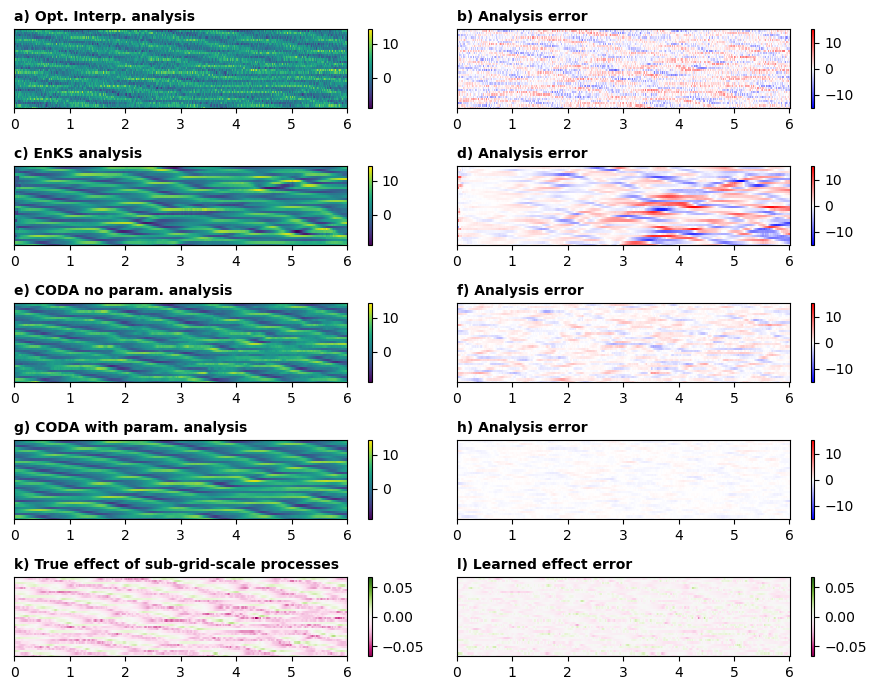

In [13]:
mosaic = """
aabb
ccdd
eeff
gghh
kkll
"""
fig, axd = plt.subplot_mosaic(mosaic, figsize=(9, 7))
time_labels = torch.arange(0, 601*0.01, 0.01)
location_labels = torch.arange(0, 36, 1)

img0 = axd["a"].pcolor(time_labels, location_labels, optimal_interpolation[:601].T, cmap="viridis", vmin=analysis_min, vmax=analysis_max)
plt.colorbar(img0, ax=axd["a"])
img1 = axd["c"].pcolor(time_labels, location_labels, enks[:601].T, cmap="viridis", vmin=analysis_min, vmax=analysis_max)
plt.colorbar(img1, ax=axd["c"])
img2 = axd["e"].pcolor(time_labels, location_labels, my_noparam[:601].T, cmap="viridis", vmin=analysis_min, vmax=analysis_max)
plt.colorbar(img2, ax=axd["e"])
img3 = axd["g"].pcolor(time_labels, location_labels, my_param[:601].T, cmap="viridis", vmin=analysis_min, vmax=analysis_max)
plt.colorbar(img3, ax=axd["g"])

img4 = axd["b"].pcolor(time_labels, location_labels, diff_optimal_interpolation[:601].T, cmap="bwr", vmin=-diff_lim, vmax=diff_lim)
plt.colorbar(img4, ax=axd["b"])
img5 = axd["d"].pcolor(time_labels, location_labels, diff_enks[:601].T, cmap="bwr", vmin=-diff_lim, vmax=diff_lim)
plt.colorbar(img5, ax=axd["d"])
img6 = axd["f"].pcolor(time_labels, location_labels, diff_my_noparam[:601].T, cmap="bwr", vmin=-diff_lim, vmax=diff_lim)
plt.colorbar(img6, ax=axd["f"])
img7 = axd["h"].pcolor(time_labels, location_labels, diff_my_param[:601].T, cmap="bwr", vmin=-diff_lim, vmax=diff_lim)
plt.colorbar(img7, ax=axd["h"])

img8 = axd["k"].pcolor(time_labels, location_labels, effect_true[:601].T, cmap="PiYG", vmin=-effect_lim, vmax=effect_lim)
plt.colorbar(img8, ax=axd["k"])

img9 = axd["l"].pcolor(time_labels, location_labels, diff_effect[:601].T, cmap="PiYG", vmin=-effect_lim, vmax=effect_lim)
plt.colorbar(img9, ax=axd["l"])

for letter, ax in axd.items():
    # ax.set_xticks(time_ticks, time_ticks_labels)
    title = f"{letter}) "
    if letter == "a":
        title += "Opt. Interp. analysis"
    elif letter == "c":
        title += "EnKS analysis"
    elif letter == "e":
        title += "CODA no param. analysis"
    elif letter == "g":
        title += "CODA with param. analysis"
    elif letter in ["b", "d", "f", "h"]:
        title += "Analysis error"
    elif letter == "k":
        title += "True effect of sub-grid-scale processes"
    elif letter == "l":
        title += "Learned effect error"
    ax.set_yticks([])
    ax.set_title(title, loc='left', fontsize=10, fontweight="bold")

plt.tight_layout()
plt.savefig("fig_7.png", dpi=300)